This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Hydrometeorclassification

In [1]:
import wradlib as wrl
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
from scipy import interpolate
import datetime as dt
import glob

The hydrometeorclassification code is based on the paper by [Zrnic et.al 2001](https://dx.doi.org/10.1175/1520-0426%282001%29018%3C0892:TAPFAC%3E2.0.CO;2) utilizing 2D trapezoidal membership functions based on the paper by [Straka et. al 2000](https://doi.org/10.1175/1520-0450(2000)039%3C1341:BHCAQU%3E2.0.CO;2) adapted by [Evaristo et. al 2013](https://ams.confex.com/ams/36Radar/webprogram/Paper229078.html) for X-Band.

## Precipitation Types

In [2]:
pr_types = wrl.classify.pr_types
for k, v in pr_types.items():
    print(str(k) + ' - '.join(v))

0LR - Light Rain
1MR - Moderate Rain
2HR - Heavy Rain
3LD - Large Drops
4HL - Hail
5RH - Rain/Hail
6GH - Graupel/Hail
7DS - Dry Snow
8WS - Wet Snow
9HC - H Crystals
10VC - V Crystals
11NP - No Precip


## Membership Functions

### Load 2D Membership Functions

In [3]:
filename = wrl.util.get_wradlib_data_file('misc/msf_xband.gz')
msf = wrl.io.get_membership_functions(filename)

### Plot 2D Membership Functions

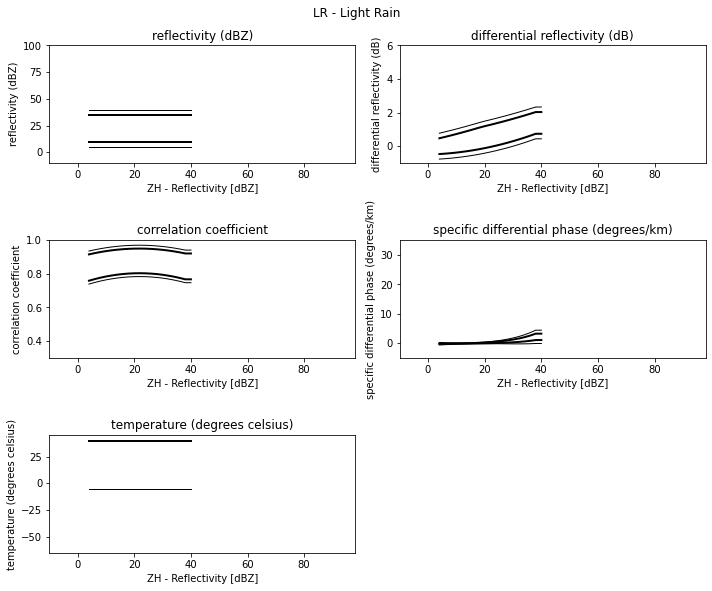

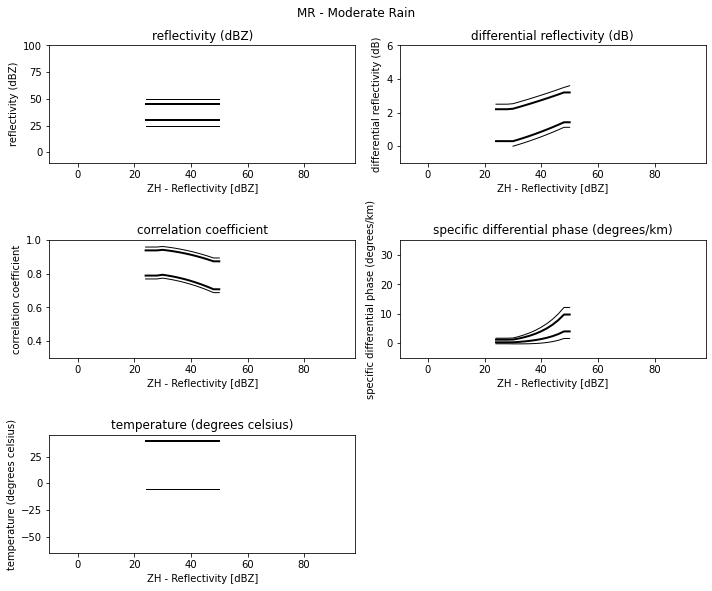

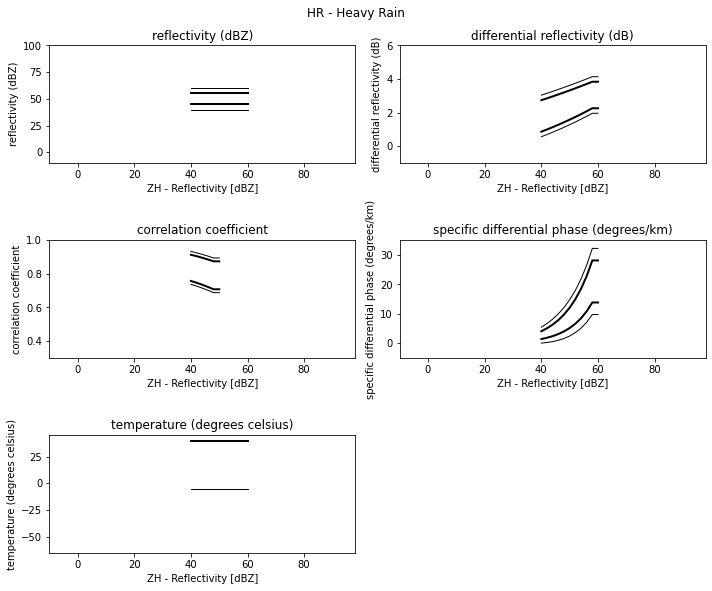

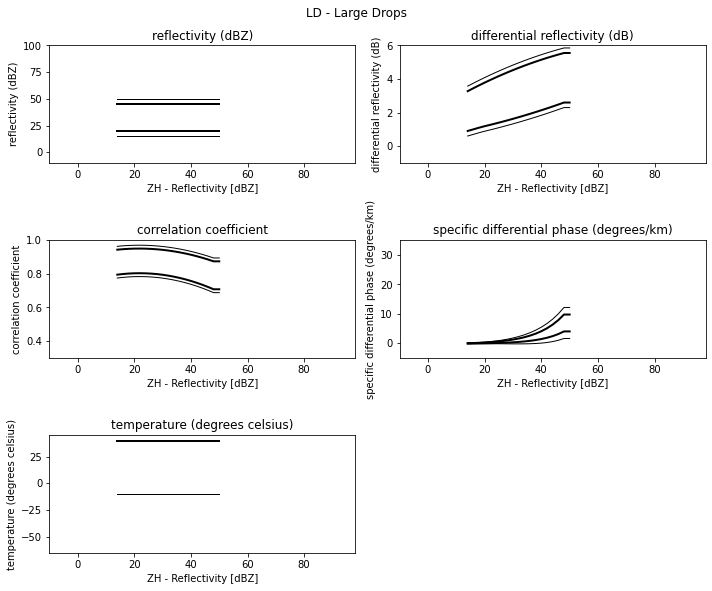

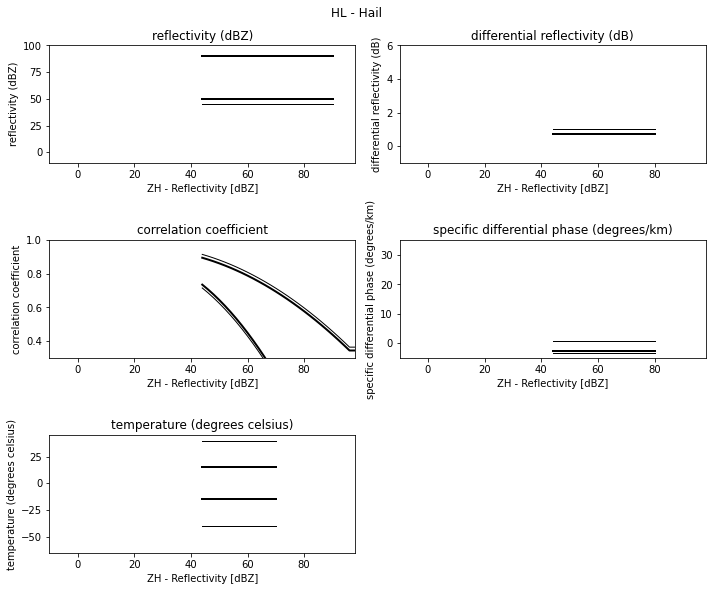

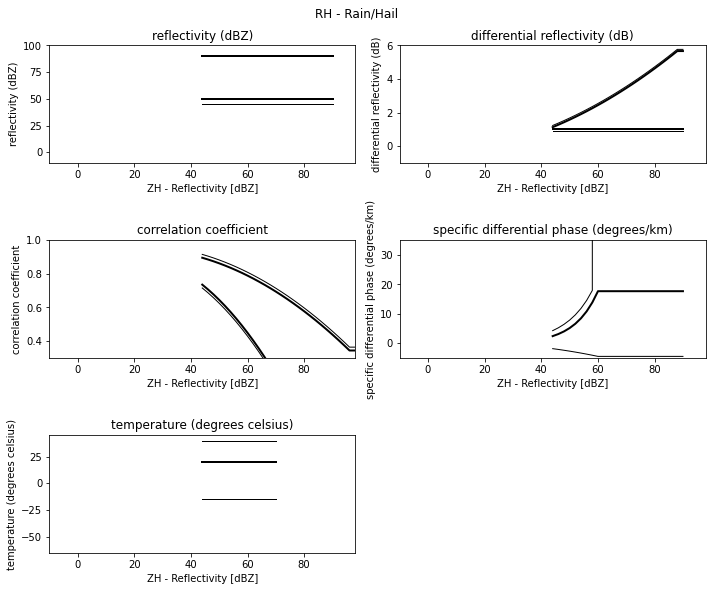

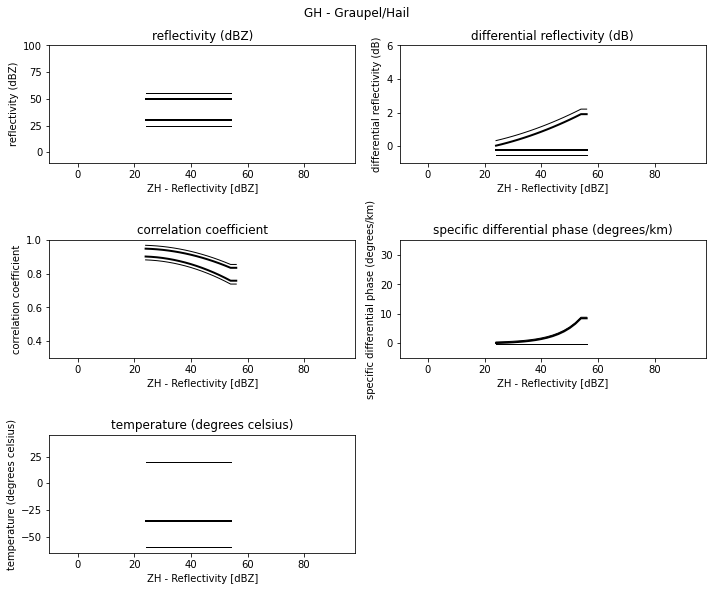

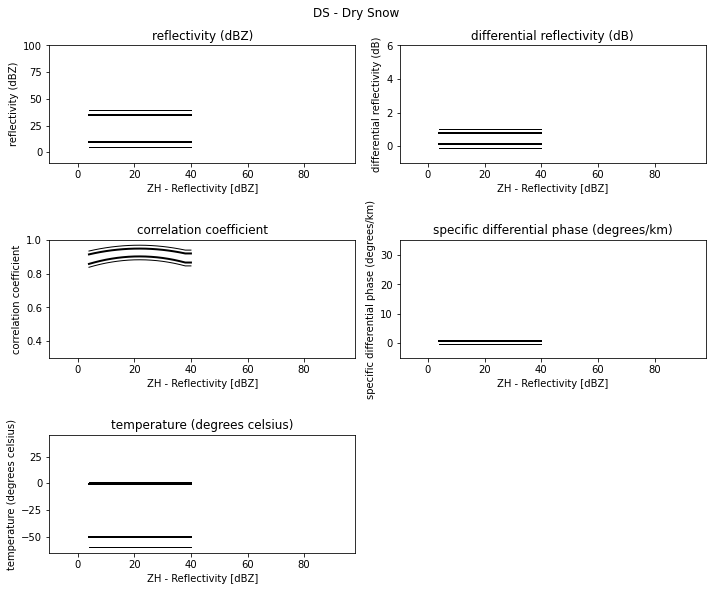

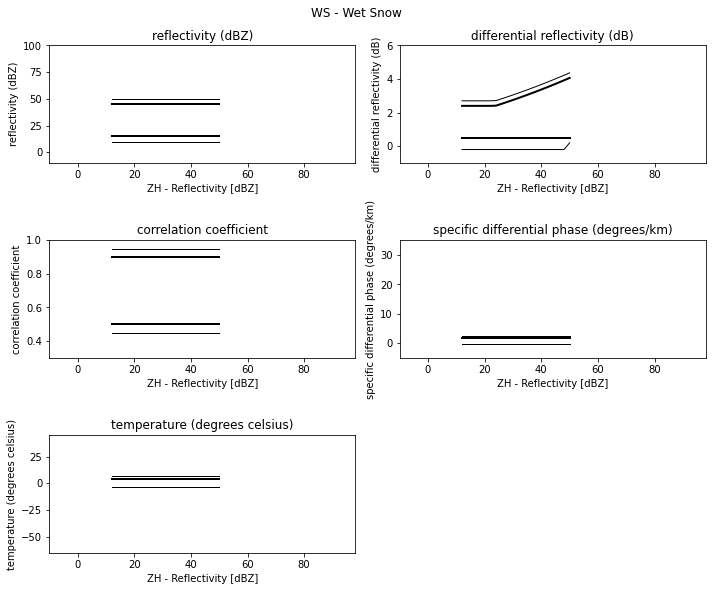

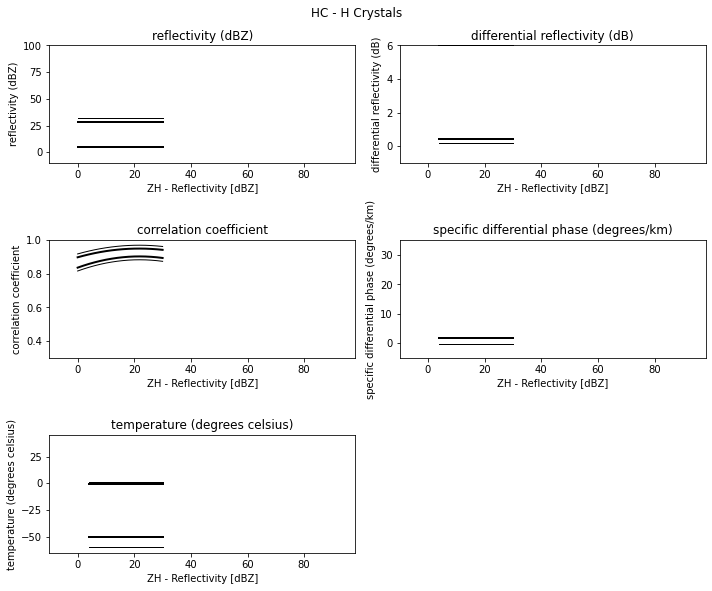

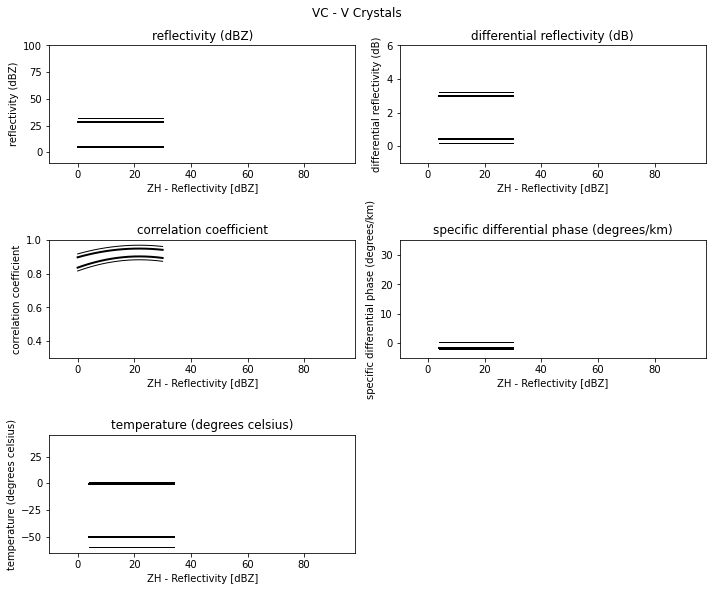

In [4]:
obs = ['reflectivity (dBZ)', 'differential reflectivity (dB)', 
       'correlation coefficient', 'specific differential phase (degrees/km)',
       'temperature (degrees celsius)']
minmax = [(-10, 100),(-1, 6), (0.3, 1.0), (-5, 35), (-65, 45)]

for i, v in enumerate(msf):
    fig = pl.figure(figsize=(10, 8))
    t = fig.suptitle(' - '.join(pr_types[i]))
    t.set_y(1.02)
    for k, p in enumerate(v):
        ax = fig.add_subplot(3,2,k+1)
        ax.plot(p[:,0],
                np.ma.masked_equal(p[:,1], 0.),
                'k', lw=1.0)
        ax.plot(p[:,0],
                np.ma.masked_equal(p[:,2], 0.),
                'k', lw=2.0)
        ax.plot(p[:,0],
                np.ma.masked_equal(p[:,3], 0.),
                'k', lw=2.0)
        ax.plot(p[:,0],
                np.ma.masked_equal(p[:,4], 0.),
                'k', lw=1.0)

        ax.set_xlim((p[:,0].min(), p[:,0].max()))
        ax.margins(x=0.05, y=0.05)
        ax.set_xlabel('ZH - Reflectivity [dBZ]')
        ax.set_ylabel(obs[k])
        t = ax.set_title(obs[k])
        ax.set_ylim(minmax[k])
    fig.tight_layout()
pl.show()

## Use Sounding Data

### Retrieve Sounding Data

To get the temperature as additional discriminator we use radiosonde data from
the [University of Wyoming](http://weather.uwyo.edu/upperair/sounding.html).

The function `get_radiosonde` tries to find the next next available radiosonde measurement on the given date.

In [5]:
rs_time = dt.datetime(2014, 6, 10, 12, 0)
import urllib
try:
    rs_data, rs_meta = wrl.io.get_radiosonde(10410, rs_time)
except urllib.error.HTTPError:
    dataf = wrl.util.get_wradlib_data_file('misc/radiosonde_10410_20140610_1200.h5')
    rs_data, _ = wrl.io.from_hdf5(dataf)
    metaf = wrl.util.get_wradlib_data_file('misc/radiosonde_10410_20140610_1200.json')
    with open(metaf, 'r') as infile:
        import json
        rs_meta = json.load(infile)
rs_meta

{'Station identifier': 'EDZE',
 'Station number': 10410,
 'Observation time': datetime.datetime(2014, 6, 10, 12, 0),
 'Station latitude': 51.4,
 'Station longitude': 6.96,
 'Station elevation': 153.0,
 'Showalter index': 1.65,
 'Lifted index': -5.84,
 'LIFT computed using virtual temperature': -6.23,
 'SWEAT index': 89.02,
 'K index': 23.7,
 'Cross totals index': 17.3,
 'Vertical totals index': 31.3,
 'Totals totals index': 48.6,
 'Convective Available Potential Energy': 1536.47,
 'CAPE using virtual temperature': 1637.41,
 'Convective Inhibition': -140.01,
 'CINS using virtual temperature': -80.22,
 'Equilibrum Level': 202.61,
 'Equilibrum Level using virtual temperature': 202.55,
 'Level of Free Convection': 735.93,
 'LFCT using virtual temperature': 772.57,
 'Bulk Richardson Number': 57.19,
 'Bulk Richardson Number using CAPV': 60.94,
 'Temp [K] of the Lifted Condensation Level': 288.2,
 'Pres [hPa] of the Lifted Condensation Level': 882.1,
 'Equivalent potential temp [K] of the LCL

### Extract Temperature and Height

In [6]:
stemp = rs_data['TEMP']
sheight = rs_data['HGHT']
# remove nans
idx = np.isfinite(stemp)
stemp = stemp[idx]
sheight = sheight[idx]

### Interpolate to higher resolution

In [7]:
# highres height
hmax = 30000.
ht = np.arange(0., hmax)

ipolfunc = interpolate.interp1d(sheight, stemp, kind='linear', 
                                bounds_error=False)
itemp = ipolfunc(ht)

### Fix Temperature below first measurement

In [8]:
first = np.nanargmax(itemp)
itemp[0:first] = itemp[first]

### Plot Temperature Profile

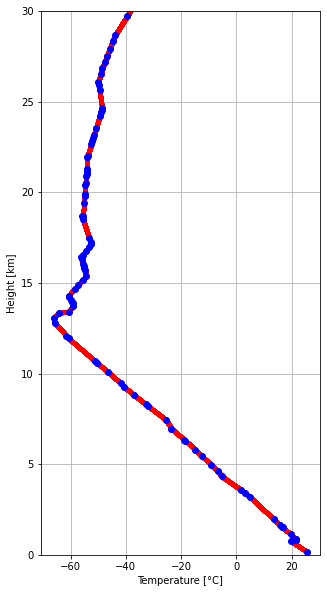

In [9]:
fig = pl.figure(figsize=(5,10))
ax = fig.add_subplot(111)
l1 = ax.plot(itemp, ht/1000, 'r.')
l2 = ax.plot(stemp, sheight/1000, 'bo')
ax.set_xlabel('Temperature [°C]')
ax.set_ylabel('Height [km]')
ax.set_ylim(0, hmax/1000)
ax.grid()
pl.show()

## Prepare Radar Data

### Load Radar Data

In [10]:
# read the radar volume scan
filename = 'hdf5/2014-06-09--185000.rhi.mvol'
filename = wrl.util.get_wradlib_data_file(filename)

### Extract data for georeferencing

In [11]:
data, meta = wrl.io.read_gamic_hdf5(filename)
r = meta['SCAN0']['r'] - meta['SCAN0']['bin_range'] / 2.
el = meta['SCAN0']['el']
az = meta['SCAN0']['az']
rays = meta['SCAN0']['ray_count']
bins = meta['SCAN0']['bin_count']
sitecoords = (meta['VOL']['Longitude'], meta['VOL']['Latitude'], 
              meta['VOL']['Height'])

### Get Heights of Radar Bins

In [12]:
re = wrl.georef.get_earth_radius(sitecoords[1])
print(r.shape, el.shape)
bheight = wrl.georef.bin_altitude(r[:, np.newaxis], el, sitecoords[2], re).T
print(bheight.shape)

(667,) (450,)
(450, 667)


### Plot RHI of Heights

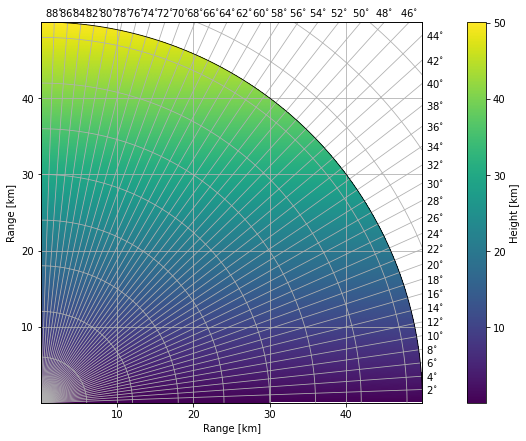

In [13]:
fig = pl.figure(figsize=(8, 7))
cmap = mpl.cm.viridis
cgax, im = wrl.vis.plot_rhi(bheight/1000., r=r/1000., th=el, 
                            proj='cg', cmap=cmap,
                            ax=111, fig=fig)
cbar = pl.colorbar(im, fraction=0.046, pad=0.1)
cbar.set_label('Height [km]')
caax = cgax.parasites[0]
caax.set_xlabel('Range [km]')
caax.set_ylabel('Range [km]')
pl.show()

### Get Index into High Res Height Array

In [14]:
idx = np.digitize(bheight, ht)
print(idx.shape, ht.shape, itemp.shape)
rtemp = itemp[idx-1]
print(rtemp.min())

(450, 667) (30000,) (30000,)
-66.1


### Plot RHI of Temperatures

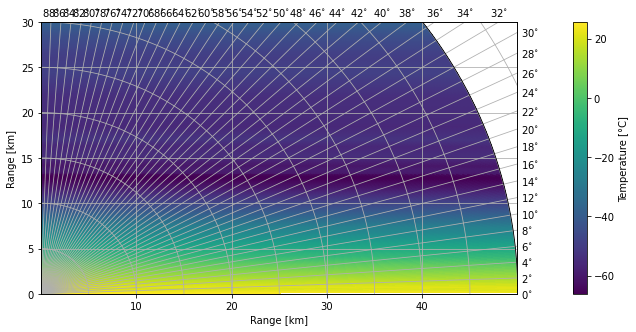

In [15]:
fig = pl.figure(figsize=(10,5))
cgax, im = wrl.vis.plot_rhi(rtemp, r=r/1000., th=el, 
                            proj='cg', cmap=cmap,
                            ax=111, fig=fig)
cbar = pl.colorbar(im, fraction=0.046, pad=0.1)
cbar.set_label('Temperature [°C]')
caax = cgax.parasites[0]
caax.set_xlabel('Range [km]')
caax.set_ylabel('Range [km]')
cgax.set_ylim(0, hmax/1000)
pl.show()

## HMC Workflow

### Stack Observables 

In [16]:
hmca = np.vstack((data['SCAN0']['ZH']['data'][np.newaxis,...], 
                  data['SCAN0']['ZDR']['data'][np.newaxis,...], 
                  data['SCAN0']['RHOHV']['data'][np.newaxis,...], 
                  data['SCAN0']['KDP']['data'][np.newaxis,...], 
                  rtemp[np.newaxis,...]))
print(hmca.shape)

(5, 450, 667)


### Setup Independent Observable $Z_H$

In [17]:
msf_idp = msf[0, 0, :, 0]
msf_obs = msf[..., 1:]

### Retrieve membership function values based on independent observable

In [18]:
msf_val = wrl.classify.msf_index_indep(msf_obs, msf_idp, 
                                       hmca[0])

### Fuzzyfication

In [19]:
fu = wrl.classify.fuzzyfi(msf_val, hmca)

### Probability

In [20]:
# Weights
w = np.array([2., 1., 1., 1., 1.])
prob = wrl.classify.probability(fu, w)

### Classification

In [21]:
hmc_idx, hmc_vals = wrl.classify.classify(prob, threshold=0.)

## Plot HMC Results

### Plot Probability of HMC Types

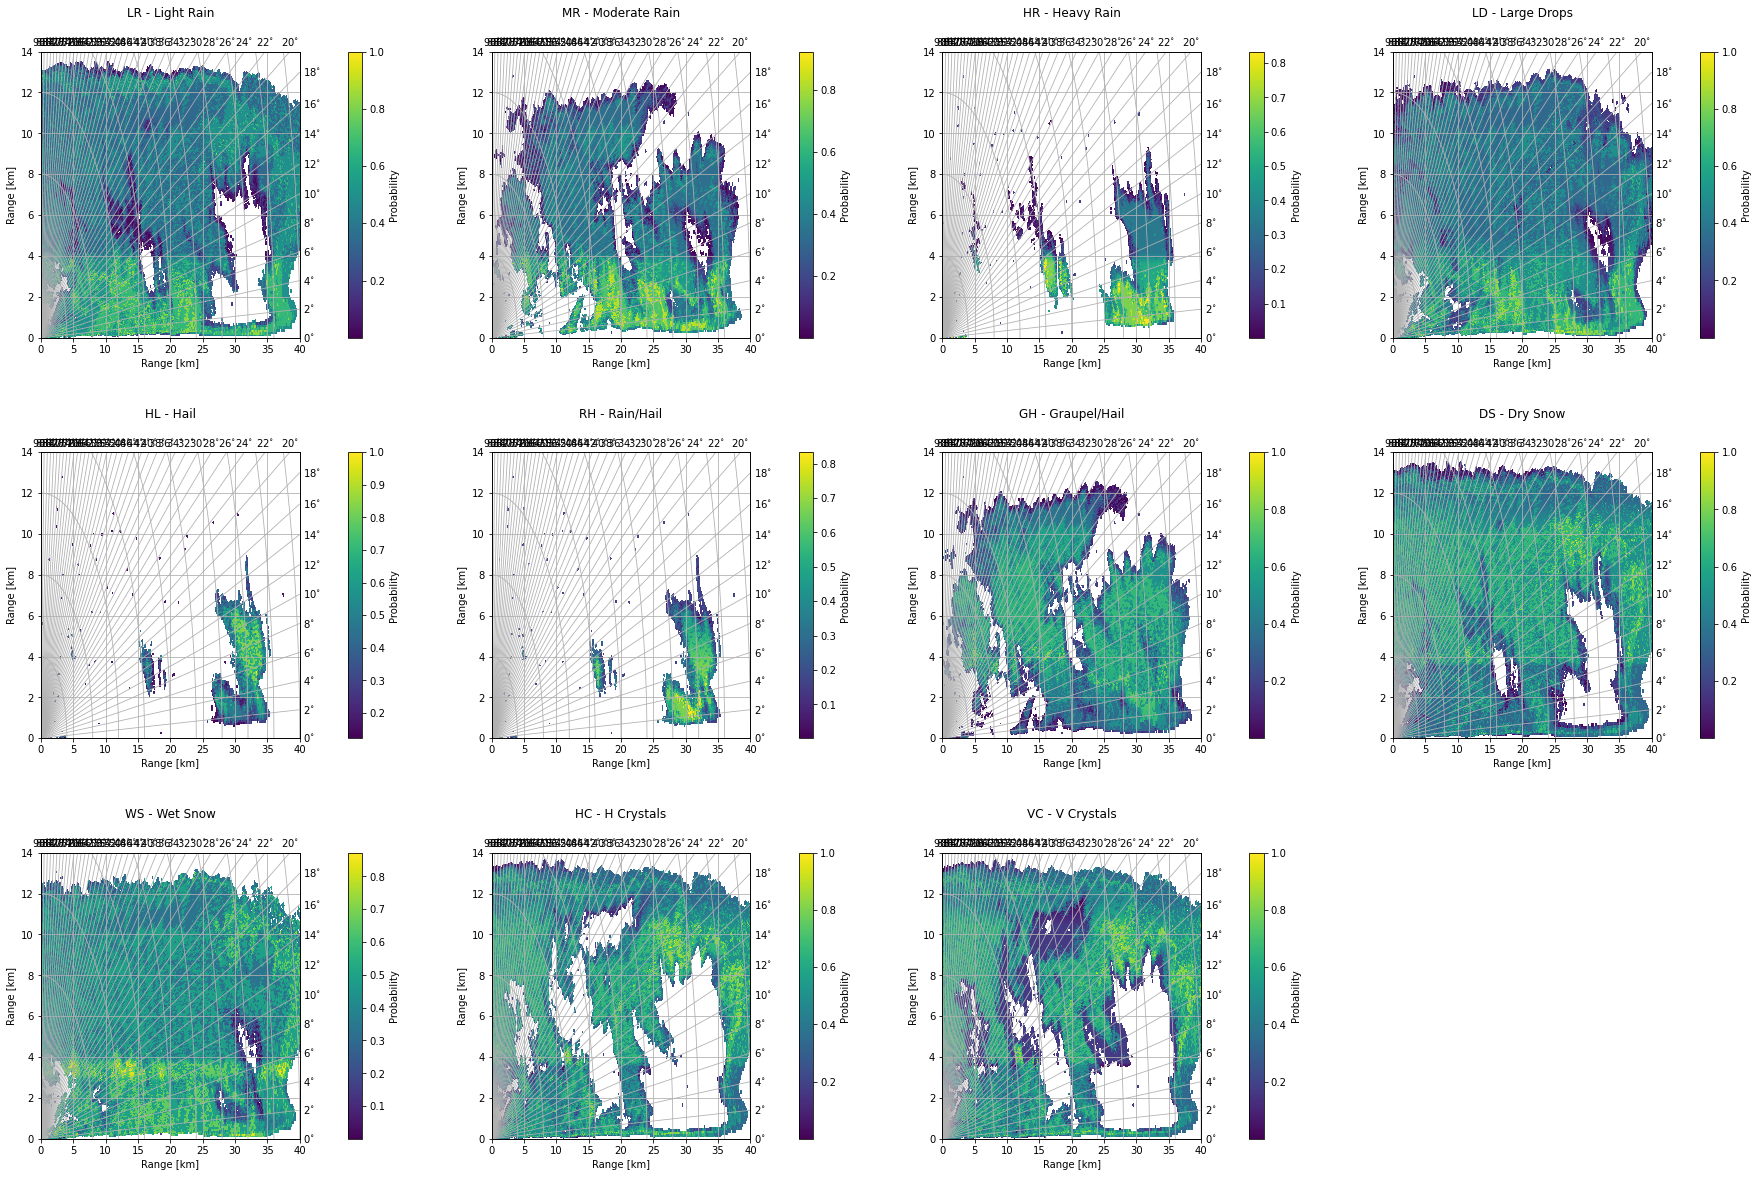

In [22]:
fig = pl.figure(figsize=(30,20))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(3, 4, wspace=0.4, hspace=0.4)
for i, c in enumerate(prob):
    cgax, im = wrl.vis.plot_rhi(np.ma.masked_less_equal(c, 0.),
                                r=r/1000., th=el,
                                proj='cg',
                                ax=gs[i], fig=fig)
    cbar = pl.colorbar(im, fraction=0.046, pad=0.15)
    cbar.set_label('Probability')
    caax = cgax.parasites[0]
    caax.set_xlabel('Range [km]')
    caax.set_ylabel('Range [km]')
    t = cgax.set_title(' - '.join(pr_types[i]))
    t.set_y(1.1) 
    cgax.set_xlim(0,40)
    cgax.set_ylim(0,14)
pl.show()

### Plot maximum  probability 

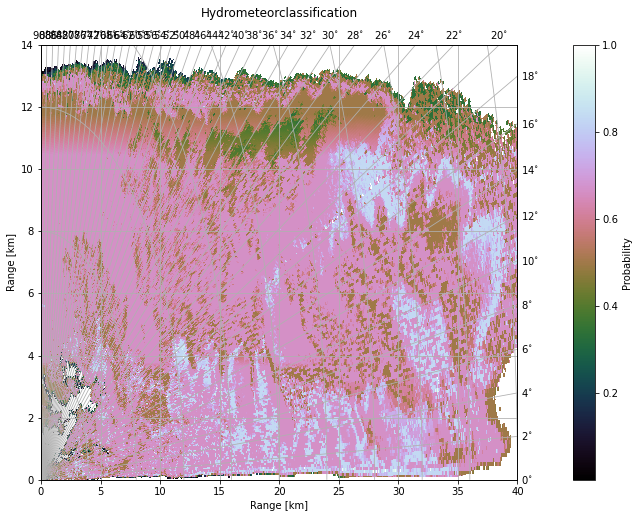

In [23]:
fig = pl.figure(figsize=(10, 8))
cgax, im = wrl.vis.plot_rhi(hmc_vals[11], ax=111, 
                            proj='cg', 
                            r=r/1000., th=el,
                            cmap='cubehelix', fig=fig)
cbar = pl.colorbar(im, fraction=0.046, pad=0.1)
cbar.set_label('Probability')
caax = cgax.parasites[0]
caax.set_xlabel('Range [km]')
caax.set_ylabel('Range [km]')
t = cgax.set_title('Hydrometeorclassification')
t.set_y(1.05)
cgax.set_xlim(0,40)
cgax.set_ylim(0,14)
pl.show()

### Plot classification result

In [24]:
bounds = np.arange(-0.5, prob.shape[0] + 0.6, 1)
ticks=np.arange(0, prob.shape[0] + 1)
cmap = mpl.cm.get_cmap('cubehelix', len(ticks))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

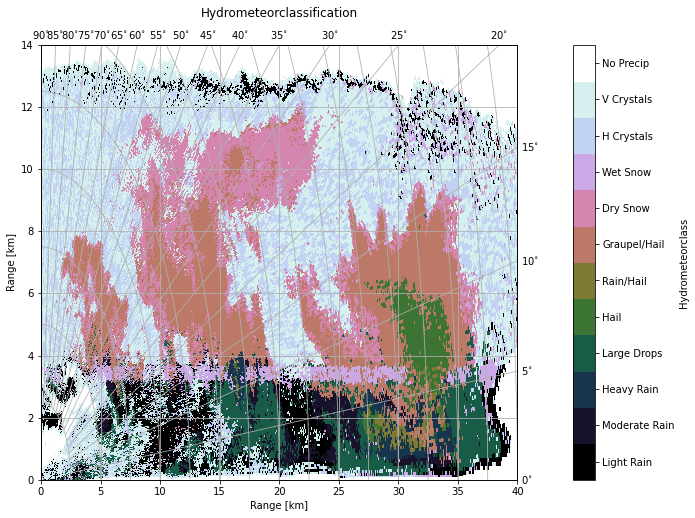

In [25]:
fig = pl.figure(figsize=(10,8))
cgax, im = wrl.vis.plot_rhi(hmc_idx[11], ax=111, 
                            proj={'angular_spacing': 20.,
                                  'radial_spacing': 12.,
                                  'latmin': 2.5}, 
                            r=r/1000., th=el,
                            norm=norm, 
                            cmap=cmap, 
                            fig=fig)
cbar = pl.colorbar(im, ticks=ticks, fraction=0.046, norm=norm, pad=0.1)
cbar.set_label('Hydrometeorclass')
caax = cgax.parasites[0]
caax.set_xlabel('Range [km]')
caax.set_ylabel('Range [km]')
labels = [pr_types[i][1] for i, _ in enumerate(pr_types)]
labels = cbar.ax.set_yticklabels(labels)
t = cgax.set_title('Hydrometeorclassification')
t.set_y(1.05)
cgax.set_xlim(0,40)
cgax.set_ylim(0,14)
pl.show()